# PSF Photometry in Crowded Fields with Photutils

##### This notebook exemplifies the use of photutils.psf to perform point spread function photometry in crowded fields artificially created assuming that stars have a known Gaussian model

## Create an artificial image

##### Let's create an artificial image using photutils.datasets functionalities

In [1]:
from photutils.datasets import make_random_gaussians
from photutils.datasets import make_noise_image
from photutils.datasets import make_gaussian_sources

num_sources = 150
min_flux = 500
max_flux = 5000
min_xmean = 16
max_xmean = 240
sigma_psf = 2.0
starlist = make_random_gaussians(num_sources, [min_flux, max_flux],
                                 [min_xmean, max_xmean],
                                 [min_xmean, max_xmean],
                                 [sigma_psf, sigma_psf],
                                 [sigma_psf, sigma_psf],
                                 random_state=123)
shape = (256, 256)
image = (make_gaussian_sources(shape, starlist) +
         make_noise_image(shape, type='poisson', mean=2., random_state=123))
print(starlist)

     flux         x_mean        y_mean    x_stddev y_stddev     theta     
------------- ------------- ------------- -------- -------- --------------
3634.11133519 53.1700860624 19.6719157162      2.0      2.0  1.54768051313
1787.62700728 190.943538112 177.545297995      2.0      2.0  2.42073188884
1520.83154104 80.1842021473 17.7332031642      2.0      2.0  1.75929157855
2980.91646087 84.6492247458 35.0001901477      2.0      2.0  4.13220116374
3737.61036404 165.018568238 66.5116439408      2.0      2.0  2.03714454696
2403.97907056 40.9518464401 212.027895588      2.0      2.0  4.73998224779
4913.43889273 164.931428532 97.4410952292      2.0      2.0 0.713198573693
3581.73382363 214.879921559 136.951025488      2.0      2.0   4.8717604856
2664.19355668 171.973724085 143.255119895      2.0      2.0  3.68133067859
2264.52883187 114.633444373 66.5037927085      2.0      2.0  5.24890192486
          ...           ...           ...      ...      ...            ...
2964.93607683 230.7061824

## Initialize instances for the DAOPhotPSFPhotometry object

##### In order to initiliaze a DAOPhotPSFPhotometry object, we have to load some other objects which will be used to perform psf photometry. More precisely, the required parts are:  a fitter (e.g., from astropy.fitting), a source detection (e.g., DAOStarFinder, from photutils.detection), a grouping functionality (e.g., DAOGroup from photutils.psf), a background estimator (e.g. MedianBackground, from photutils.background), and a psf model (e.g., IntegratedGaussianPRF from photutils.psf).

In [2]:
from photutils.detection import DAOStarFinder
from photutils.psf import DAOGroup
from photutils.psf import IntegratedGaussianPRF
from photutils.background import MedianBackground
from photutils.background import StdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

bkgrms = StdBackgroundRMS(sigma=3.)

std = bkgrms(image)

daofind = DAOStarFinder(threshold=5.0*std,
                        fwhm=sigma_psf*gaussian_sigma_to_fwhm)

daogroup = DAOGroup(1.5*sigma_psf*gaussian_sigma_to_fwhm)

median_bkg = MedianBackground(sigma=3.)

psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

fitter = LevMarLSQFitter()

## Perform photometry

##### To actually perform psf photometry, we need first to initialize an DAOPhotPSFPhotometry object by passing along the objects loaded in the previous cell. Similarly to DAOGroup and DAOStarFinder, DAOPhotPSFPhotometry class was designed such that its objetcs are callable, which means that one can call them in the same fashion as calling a function. This, in fact, will call the appropriate method to perform photometry. 

In [3]:
from photutils.psf import DAOPhotPSFPhotometry

daophot_photometry = DAOPhotPSFPhotometry(find=daofind, group=daogroup,
                                          bkg=median_bkg, psf=psf_model,
                                          fitter=LevMarLSQFitter(),
                                          niters=2, fitshape=(11,11))
result_tab, residual_image = daophot_photometry(image=image)

## Plot original and residual images

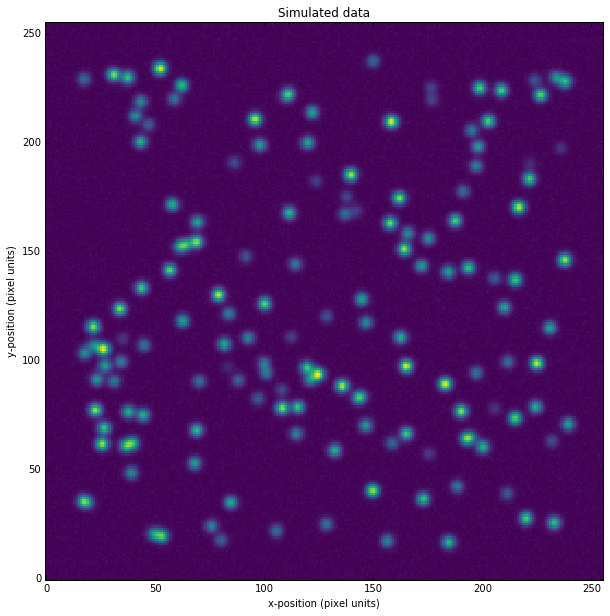

In [4]:
import numpy as np
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (20,10)
rcParams['image.interpolation'] = 'nearest'
rcParams['image.origin'] = 'lower'

plt.imshow(image)
#for i, row in enumerate(starlist):
#    plt.annotate(str(i+1), (row['x_mean'], row['y_mean']), 
#                 (5, 5), textcoords='offset points', 
#                 color='w')
plt.title('Simulated data')
plt.xlabel('x-position (pixel units)')
plt.ylabel('y-position (pixel units)')

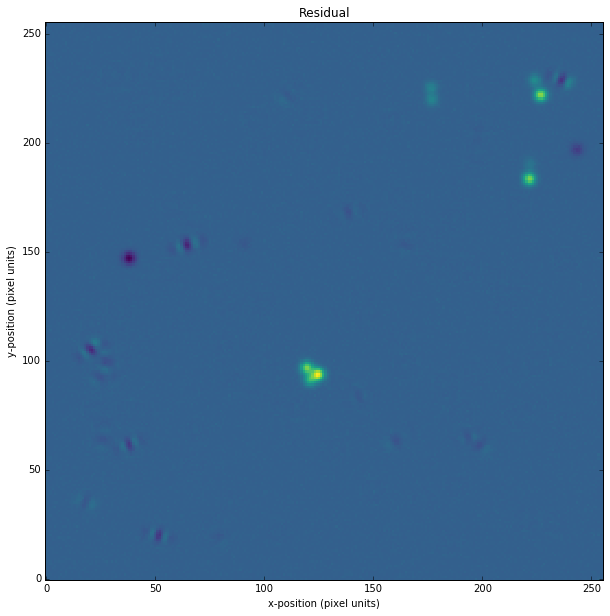

In [5]:
plt.imshow(residual_image)
plt.title('Residual')
plt.xlabel('x-position (pixel units)')
plt.ylabel('y-position (pixel units)')

In [6]:
result_tab.sort('id')
print(result_tab)

 id group_id     x_fit         y_fit         flux_fit   iter_detected
--- -------- ------------- -------------- ------------- -------------
  1        1 156.310524754  17.3726963174 2320.85719711             1
  1        1  55.757152153  19.0613769086  687.26388874             2
  2        2 184.362201414  16.7971024396 3391.98003282             1
  2        2 47.4763846544  21.0038015397 1090.52761976             2
  3        3 79.9925283202  18.0024212963 1615.39475725             1
  3        3 34.0897363124  59.9938744609 738.253823344             2
  4        4 51.8692402704  19.9916410505 4966.15659716             1
  4        4 41.9691824978  63.0616750264 728.863388889             2
  5        5 105.465571982  21.9678196875 1839.12831334             1
  5        5 189.392925173  63.3194078099 186.838316295             2
...      ...           ...            ...           ...           ...
130      116 176.533698798    221.6103445 1253.27916464             1
131      121 198.538

## Photometry with fixed positions
##### Now, let's perform photometry for the case that star positions are held fixed and one is interested only in fitting the flux.

In [7]:
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True

In [8]:
positions = starlist['x_mean', 'y_mean']
positions['x_mean'].name = 'x_0'
positions['y_mean'].name = 'y_0'

In [9]:
daophot_photometry = DAOPhotPSFPhotometry(group=daogroup,
                                          bkg=median_bkg, psf=psf_model,
                                          fitter=LevMarLSQFitter(),
                                          fitshape=(11,11))
result_tab, residual_image = daophot_photometry(image=image, positions=positions)

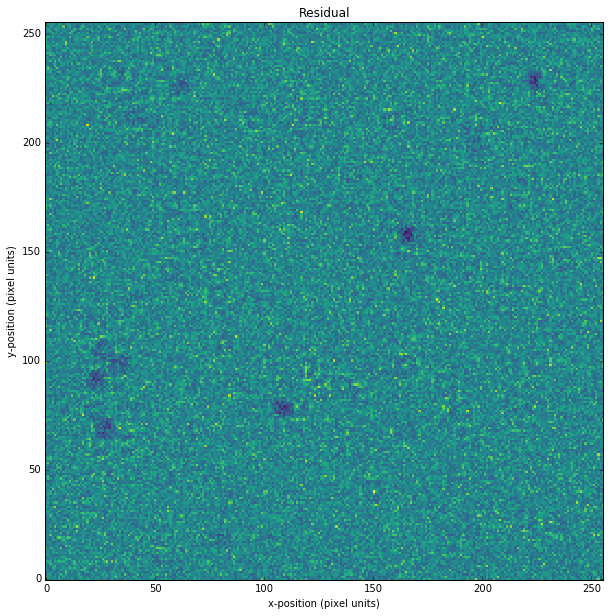

In [10]:
plt.imshow(residual_image)
plt.title('Residual')
plt.xlabel('x-position (pixel units)')
plt.ylabel('y-position (pixel units)')

In [11]:
result_tab.sort('id')
print(result_tab)

 id group_id     x_fit         y_fit        flux_fit  
--- -------- ------------- ------------- -------------
  1        1 53.1700860624 19.6719157162 3659.94479117
  2        2 190.943538112 177.545297995 1809.73144344
  3        3 80.1842021473 17.7332031642 1607.39478285
  4        4 84.6492247458 35.0001901477 3028.95838722
  5        5 165.018568238 66.5116439408 3782.67943035
  6        6 40.9518464401 212.027895588 2482.70494629
  7        7 164.931428532 97.4410952292 4980.90859872
  8        8 214.879921559 136.951025488 3609.35868929
  9        9 171.973724085 143.255119895 2690.78615661
 10       10 114.633444373 66.5037927085 2285.88353754
...      ...           ...           ...           ...
140      119 230.706182437 114.940214922 2978.16932055
141      120 112.278187687 110.868042971  921.93954346
142      121 211.524876808  99.326159375  1836.3118867
143      122 95.7345176261 210.502495079 4721.75527217
144      123  224.26705825 78.8268436649 3102.81065979
145       

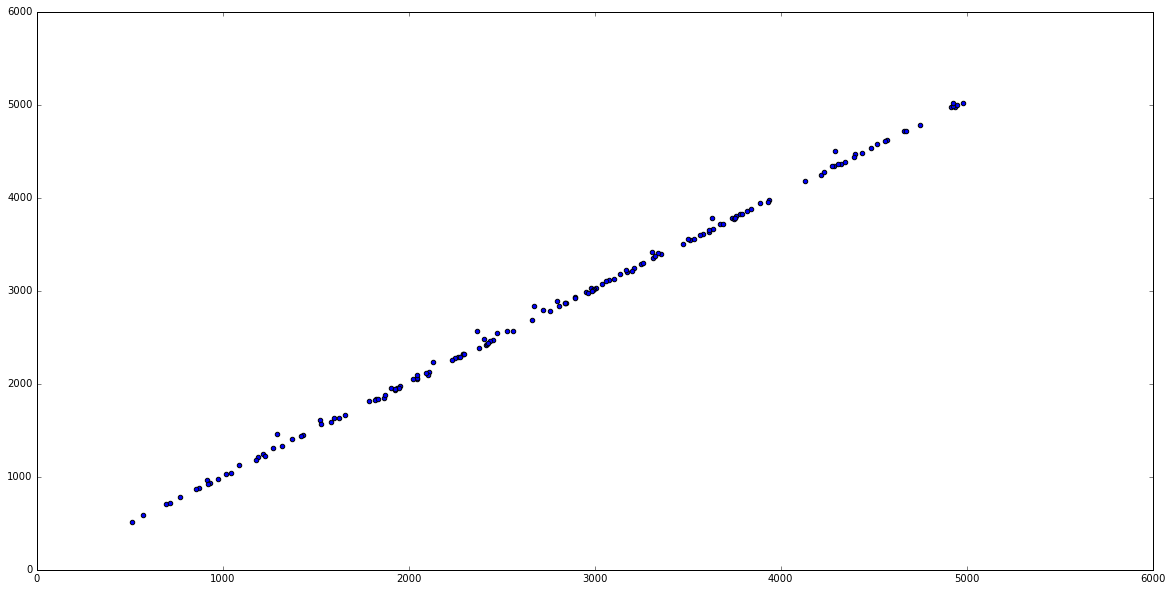

In [12]:
plt.scatter(starlist['flux'], result_tab['flux_fit'])

In [13]:
print(np.corrcoef(starlist['flux'], result_tab['flux_fit'])[0][1])
print(np.sqrt(np.mean((starlist['flux'] - result_tab['flux_fit'])**2)))

0.999623914431
50.7171113743
